# Forecasting Prediction Using Exponential Smoothing

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/train.csv')

In [3]:
data_1_1 = data[data['store'] == 1]
data_1_1 = data_1_1[data_1_1['item'] == 1]
data_1_1 = data_1_1[['date','sales']]
data_1_1 = data_1_1.set_index('date')

In [4]:
first_diff = data_1_1.sales - data_1_1.sales.shift(1)
first_diff = first_diff.dropna()

In [5]:
cutoff_date = '2017-10-01'

train = first_diff.loc[first_diff.index < cutoff_date]
test = first_diff.loc[first_diff.index >= cutoff_date]

train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

## Preprocessing data for Simple Exponential Smoothing

## Simple Exponential Smoothing

* One of the simplest ways to forecast a time series.
* One of the main advantages it has over simple forecasting methods such as Naive and Moving Average is that the weight put on each observation decreases exponentially. The most recent observation has the highest weight. Moving Average gives the same weight to all historical data.

#### How it works

$$f_t = \alpha d_{t-1} + (1 - \alpha)f_{t-1}$$

* At each period, the model will learn a bit from the most recent demand observation and remember a bit of the last forecast it did.
* $\alpha$ is the importance given to the most recent demand history. The values of $\alpha$ range from 0 to 1.
* There is a tradeoff with $\alpha$:
    * If $\alpha$ is too large, the model will be reactive to change in demand level, however will be sensitive to noise and outliers.
    * If $\alpha$ is too small, the model will be less sensitive to noise and outliers, however the model will not react rapidly to changes in demand level.

#### Why is it called Exponential Smoothing?

The reason why it is called Exponential Smoothing is because the weight given to each demand observation is exponentially reduced by a factor of $(1- \alpha)$

$$f_t = \alpha d_{t-1} + (1 - \alpha)f_{t-1}$$
$$ = \alpha d_{t-1} + (1 - \alpha)(\alpha d_{t-2} + (1 - \alpha)f_{t-2})$$
$$ = \alpha d_{t-1} + \alpha(1 - \alpha)d_{t-2} + (1 - \alpha)^2f_{t-2})$$

The weight given to $d_{t-2}$ is $\alpha(1-\alpha)$ which is lower than the weight given to $d_{t-1}$

We can further decompose this formula to see that the weight of $d_{t-3}$ is even less

$$ = \alpha d_{t-1} + \alpha(1 - \alpha)d_{t-2} + (1 - \alpha)^2f_{t-2})$$
$$ = \alpha d_{t-1} + \alpha(1 - \alpha)d_{t-2} + (1 - \alpha)^2(\alpha d_{t-3} + (1 - \alpha)f_{t-3})$$
$$ = \alpha d_{t-1} + \alpha(1 - \alpha)d_{t-2} + (1 - \alpha)^2 d_{t-3} + (1 - \alpha)^3 f_{t-3}$$

The weight of $d_{t-3}$ is $\alpha (1 - \alpha)^2$. It is further reduced from the previous demand by a factor of $(1 - \alpha)$

### Implementing Simple Exponential Smoothing Model

#### Implementing by hand

In [6]:
def simple_exponential_smoothing(d, extra_periods, alpha):
    # Historical period length
    cols = len(d)
    # Append np.nan into the demand array to cover future periods
    d = np.append(d,[np.nan]*extra_periods)

    # Forecast array
    f = np.full(cols+extra_periods,np.nan)
    # initialization of first forecast
    f[1] = d[0]

    # Create all the t+1 forecast until end of historical period
    for t in range(2,cols+1):
        f[t] = alpha*d[t-1]+(1-alpha)*f[t-1]

    # Forecast for all extra periods
    for t in range(cols+1,cols+extra_periods):
    # Update the forecast as the previous forecast
        f[t] = f[t-1]

    df = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Error':d-f}) 
    return df

In [7]:
results = simple_exponential_smoothing(train, len(test), 1.0)

In [8]:
results

,Demand,Forecast,Error
0,-2.0,NaN,NaN
1,3.0,-2.0,5.0
2,-1.0,3.0,-4.0
3,-3.0,-1.0,-2.0
4,2.0,-3.0,5.0
...,...,...,...
1820,NaN,2.0,NaN
1821,NaN,2.0,NaN
1822,NaN,2.0,NaN
1823,NaN,2.0,NaN


In [9]:
predictions = results[-len(test):]['Forecast']

In [10]:
index_values = test.index.values

In [11]:
predictions = predictions.set_axis(index_values)

Text(0.5, 1.0, 'Simple Exponential Smoothing Prediction')

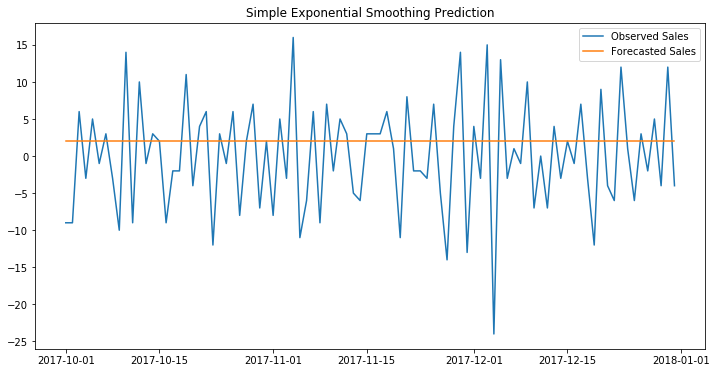

In [12]:
fig = plt.figure(figsize = (12,6))
sales = plt.plot(test, label = 'Observed Sales')
forecast = plt.plot(predictions, label = 'Forecasted Sales')
plt.legend(loc = 'best')
plt.title("Simple Exponential Smoothing Prediction")

In [13]:
print('Simple Exponential Smoothing MAE = ', mean_absolute_error(predictions, test))

Simple Exponential Smoothing MAE =  6.163043478260869


#### Implementing Using Statsmodel

In [18]:
ses = SimpleExpSmoothing(train)

alpha = 1.0
model = ses.fit(smoothing_level = alpha, optimized = False)

In [19]:
forecast = model.forecast(len(test))

Text(0.5, 1.0, 'Simple Exponential Smoothing Prediction')

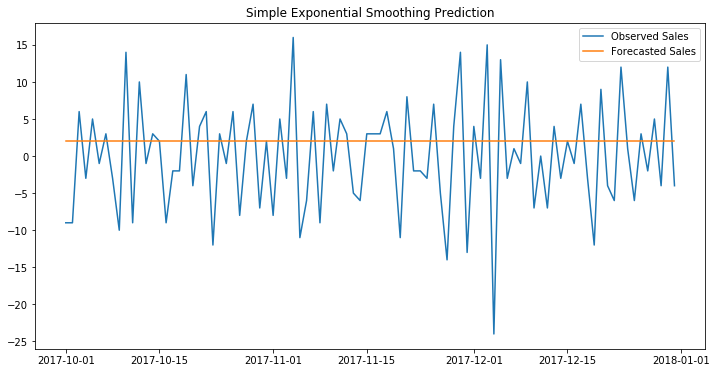

In [16]:
fig = plt.figure(figsize = (12,6))
sales = plt.plot(test, label = 'Observed Sales')
forecast_val = plt.plot(forecast, label = 'Forecasted Sales')
plt.legend(loc = 'best')
plt.title("Simple Exponential Smoothing Prediction")

In [20]:
print('Simple Exponential Smoothing MAE = ', mean_absolute_error(forecast, test))

Simple Exponential Smoothing MAE =  6.163043478260869


### Limitations of Simple Exponential Smoothing

* Simple Exponential Smoothing is unable to project trends.
* Simple Exponential Smoothing is unable to recognize any seasonal pattern
* Underfitting

## Double Exponential Smoothing

* Double Exponential Smoothing is an extended form of Simple Exponential Smoothing as it includes a trend component in its estimation.
* Double Exponential Smoothing has two smoothing equations. One to estimate the level, the other to estimate the trend
* Double Exponential Smoothing will estimate the trend based on an exponential weight $\beta$. More or less importance will be given to most recent observations.

### Equation

The forecast is computed using two equations: Level and Trend

$$Forecast = Level + Trend$$
$$f_{t+1} = a_t + b_t$$

#### Level Estimation

This component of the forecast equation is used to estimate the level of the time-series.

$$a_t = \alpha d_t + (1-\alpha)(a_{t-1} + b_{t-1})$$

This equation is very similar to the equation for Simple Exponential Smoothing. The model will update $a_t$ at each period using the previous demand value. The previous level estimation ($a_{t-1}$) is increased by the previous trend estimation ($b_{t-1}$)

$\alpha$ is the importance given to the most recent demand history. The values of $\alpha$ range from 0 to 1.

#### Trend Estimation

This component of the forecast equation is used to estimate the trend of the time-series.

$$b_t = \beta(a_t - a_{t-1}) + (1-\beta)b_{t-1}$$

$\beta$ is the learning parameter for the trend. The values of $\beta$ range from 0 to 1.

#### Full Forecast Equation

The full model used to generate forecasts of period t + $\lambda$:

$$a_t = \alpha d_t + (1-\alpha)(a_{t-1} + b_{t-1})$$
$$b_t = \beta(a_t - a_{t-1}) + (1-\beta)b_{t-1}$$
$$f_{t+\lambda} = a_t + \lambda b_t$$

### Implementing Double Exponential Smoothing Model

In [21]:
def double_exponential_smoothing(d, extra_periods, alpha, beta):
    

    # Historical period length
    cols = len(d)
    # Append np.nan into the demand array to cover future periods
    d = np.append(d,[np.nan]*extra_periods)

    # Creation of the level, trend and forecast arrays
    f,a,b = np.full((3,cols+extra_periods),np.nan)

    # Level & Trend initialization
    a[0] = d[0]
    b[0] = d[1] - d[0]

    # Create all the t+1 forecast
    for t in range(1,cols):
        f[t] = a[t-1] + b[t-1]
        a[t] = alpha*d[t] + (1-alpha)*(a[t-1]+b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*b[t-1]

    # Forecast for all extra periods
    for t in range(cols,cols+extra_periods):
        f[t] = a[t-1] + b[t-1]
        a[t] = f[t]
        b[t] = b[t-1]

    df = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Level':a, 
        'Trend':b, 'Error':d-f})

    return df

In [22]:
double_results = double_exponential_smoothing(train, len(test), 1.0, 1.0)

In [23]:
double_results

,Demand,Forecast,Level,Trend,Error
0,-2.0,NaN,-2.0,5.0,NaN
1,3.0,3.0,3.0,5.0,0.0
2,-1.0,8.0,-1.0,-4.0,-9.0
3,-3.0,-5.0,-3.0,-2.0,2.0
4,2.0,-5.0,2.0,5.0,7.0
...,...,...,...,...,...
1820,NaN,-262.0,-262.0,-3.0,NaN
1821,NaN,-265.0,-265.0,-3.0,NaN
1822,NaN,-268.0,-268.0,-3.0,NaN
1823,NaN,-271.0,-271.0,-3.0,NaN


In [24]:
double_predictions = double_results[-len(test):]['Forecast']

In [25]:
double_predictions = double_predictions.set_axis(index_values)

Text(0.5, 1.0, 'Double Exponential Smoothing Prediction')

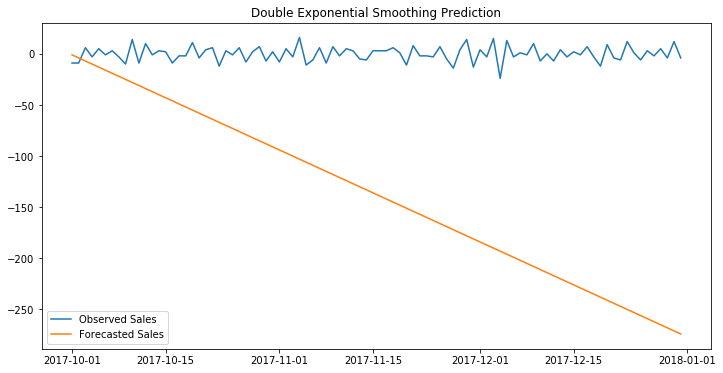

In [26]:
fig = plt.figure(figsize = (12,6))
sales = plt.plot(test, label = 'Observed Sales')
forecast = plt.plot(double_predictions, label = 'Forecasted Sales')
plt.legend(loc = 'best')
plt.title("Double Exponential Smoothing Prediction")

#### Limitations

* Double Exponential Smoothing assumes that the trend is ever going. This can be see by the above plot as the forecasted sales keeps decreasing because that was the last trend it observed.
* This can be problematic for mid- and long-term forecasts.
* Double Exponential Smoothing model is unable to recognize seasonality.
* Can't take external information

## Double Exponential Smoothing with Damped Trend

* Double Exponential Smoothing with Damped Trend is basically the same model with an added factor $\phi$
* This $\phi$ factor exponentially reduces the trend over time.
* The trend $b$ will be reduced by a factor of $\phi$ in each period.
* In theory, $\phi$ can be between 0 and 1, however for practical use it will be between 0.7 and 1. This is because:
    * $\phi = 0$ is basically the same thing as having Simple Exponential Model
    * $\phi = 1$ is basically the same thing as having Double Exponential Model

### Equation

Double Exponential Smoothing with Damped Trend is implemented by multiplying all instances of $b_{t-1}$ by $\phi$

$$a_t = \alpha d_t + (1-\alpha)(\alpha_{t-1} + \phi b_{t-1})$$
$$b_t = \beta(a_t - a_{t-1}) + (1-\beta)\phi b_{t-1}$$

The forecast for the next period would be
$$f_{t+1} = a_t + b_t \phi$$

A more general equation for forecast made on period t for period t $+ \lambda$

$$f_{t+\lambda} = a_t + b_t \sum_{i=1}^\lambda \phi^i$$

### Implementing Double Exponential Smoothing Model with Damped Trend

In [29]:
def double_exponential_smooth_damped(d, extra_periods, alpha, beta, phi):

    # Historical period length
    cols = len(d) 
    # Append np.nan into the demand array to cover future periods
    d = np.append(d,[np.nan]*extra_periods) 

    # Creation of the level, trend, and forecast arrays
    f,a,b = np.full((3,cols+extra_periods),np.nan)

    # Level & Trend initialization
    a[0] = d[0]
    b[0] = d[1] - d[0]
    
    # Create all the t+1 forecast
    for t in range(1,cols):
        f[t] = a[t-1] + phi*b[t-1]
        a[t] = alpha*d[t] + (1-alpha)*(a[t-1]+phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]

    # Forecast for all extra periods
    for t in range(cols,cols+extra_periods):
        f[t] = a[t-1] + phi*b[t-1]
        a[t] = f[t]
        b[t] = phi*b[t-1]

    df = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Level':a,'Trend':b, 'Error':d-f})

    return df

In [30]:
double_damp_results = double_exponential_smooth_damped(train, len(test), 1.0, 1.0, 0.9)

In [31]:
double_damp_results

,Demand,Forecast,Level,Trend,Error
0,-2.0,NaN,-2.000000,5.000000,NaN
1,3.0,2.500000,3.000000,5.000000,0.5
2,-1.0,7.500000,-1.000000,-4.000000,-8.5
3,-3.0,-4.600000,-3.000000,-2.000000,1.6
4,2.0,-4.800000,2.000000,5.000000,6.8
...,...,...,...,...,...
1820,NaN,-24.997461,-24.997461,-0.000282,NaN
1821,NaN,-24.997715,-24.997715,-0.000254,NaN
1822,NaN,-24.997943,-24.997943,-0.000229,NaN
1823,NaN,-24.998149,-24.998149,-0.000206,NaN


In [32]:
double_damp_predictions = double_damp_results[-len(test):]['Forecast']

In [33]:
double_damp_predictions = double_damp_predictions.set_axis(index_values)

Text(0.5, 1.0, 'Double Exponential Smoothing with Damped Trend Prediction')

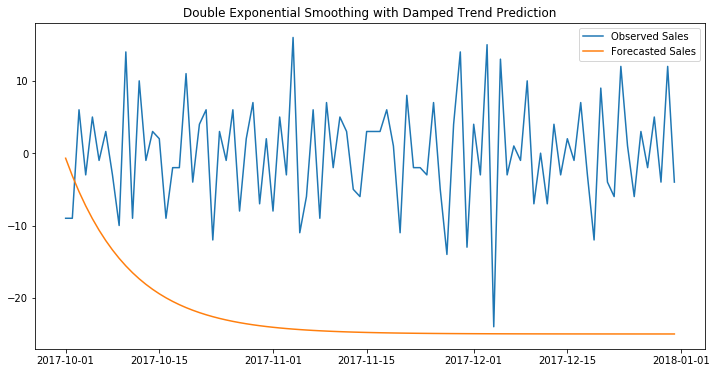

In [34]:
fig = plt.figure(figsize = (12,6))
sales = plt.plot(test, label = 'Observed Sales')
forecast = plt.plot(double_damp_predictions, label = 'Forecasted Sales')
plt.legend(loc = 'best')
plt.title("Double Exponential Smoothing with Damped Trend Prediction")

As seen from the above figure, the damp factor forgets the trend as overtime the forecasted sales line becomes horizontal reaching a stable level.

#### Limitations